# Convolutional Neural Networks II

## Model: Forecasting the Stock Market using the Stock Market

In [1]:
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import Adam
from keras.initializers import *

from sklearn.model_selection import train_test_split

import seaborn as sns

/Users/mattbrems/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/mattbrems/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
data_original = pd.read_csv('../AAPL1216.csv')[::-1]

In [3]:
# Check out the head of our data.

data_original.head()

,Date,Open,High,Low,Close,Volume,Adj Close
1005,2012-01-03,409.399998,412.499989,408.999989,411.230000,75555200,53.278774
1004,2012-01-04,410.000011,414.680012,409.279995,413.440010,65005500,53.565102
1003,2012-01-05,414.950005,418.550007,412.670006,418.029995,67817400,54.159778
1002,2012-01-06,419.770008,422.749996,419.220009,422.400002,79573200,54.725955
1001,2012-01-09,425.499992,427.750004,421.349991,421.730000,98506100,54.639149


In [4]:
## Convert Pandas Series into lists

openp = data_original.loc[:, 'Open'].tolist()
highp = data_original.loc[:, 'High'].tolist()
lowp = data_original.loc[:, 'Low'].tolist()
closep = data_original.loc[:, 'Adj Close'].tolist()
volumep = data_original.loc[:, 'Volume'].tolist()
data_chng = data_original.loc[:, 'Adj Close'].pct_change().dropna().tolist()

In [5]:


WINDOW = 30
EMB_SIZE = 6  # "Embedding size" a.k.a. input size
STEP = 1
FORECAST = 1

X, Y = [], []

In [6]:
for i in range(0, len(data_original), STEP): 
    try:
        # What is this code doing?
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]
        d = data_chng[i:i+WINDOW]

        # What is this code doing?
        o = (np.array(o) - np.mean(o)) / np.std(o)
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)
        d = (np.array(d) - np.mean(d)) / np.std(d)

        # What is this code doing?
        x_i = closep[i:i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]  

        last_close = x_i[-1]
        next_close = y_i

        # What is this code doing?
        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v, d))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

In [7]:
# Split data into training and testing sets.

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.25, 
                                                    random_state = 42)

# Reshape our data.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [8]:
# Instantiate sequential model.

model = Sequential()

# Add convolutional layer with 16 filters and a filter size of 4, with the "same" padding.

model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        filters = 16,
                        kernel_size = 4,
                        padding = 'same'))

# Normalize outputs from previous layer.
model.add(BatchNormalization())
                               
# Leaky ReLU activation function.
model.add(LeakyReLU())

# Dropout of 50%.
model.add(Dropout(0.5))

In [9]:
# Add another convolutional layer, this time with 8 filters and a filter size of 4, with the "same" padding.

model.add(Convolution1D(filters = 8,
                        kernel_size = 4,
                        padding = 'same'))

# Normalize outputs from previous layer.
model.add(BatchNormalization())

# Leaky ReLU activation function.
model.add(LeakyReLU())

# Dropout of 50%.
model.add(Dropout(0.5))

In [10]:
# What do we need to do in order to pass our data into a fully connected layer?
model.add(Flatten())

# Now let's fully connect to 64 nodes.
model.add(Dense(64))

# Normalize outputs from previous layer.
model.add(BatchNormalization())

# Leaky ReLU activation function.
model.add(LeakyReLU())

In [11]:
# How many outputs should we have?
model.add(Dense(2))

# What should our activation function be here?
model.add(Activation('softmax'))

In [12]:
# Compile our model!
model.compile(optimizer = 'adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Save the fit as history.
history = model.fit(X_train, Y_train, 
          epochs = 100, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

Train on 731 samples, validate on 244 samples
Epoch 1/100
731/731 [==============================] - 1s 2ms/step - loss: 0.9556 - acc: 0.4843 - val_loss: 0.7372 - val_acc: 0.5246
Epoch 2/100
731/731 [==============================] - 0s 123us/step - loss: 0.8711 - acc: 0.4843 - val_loss: 0.7182 - val_acc: 0.5410
Epoch 3/100
731/731 [==============================] - 0s 125us/step - loss: 0.7782 - acc: 0.5376 - val_loss: 0.7050 - val_acc: 0.5328
Epoch 4/100
731/731 [==============================] - 0s 111us/step - loss: 0.7359 - acc: 0.5513 - val_loss: 0.6955 - val_acc: 0.5205
Epoch 5/100
731/731 [==============================] - 0s 94us/step - loss: 0.7009 - acc: 0.5568 - val_loss: 0.6904 - val_acc: 0.5164
Epoch 6/100
731/731 [==============================] - 0s 131us/step - loss: 0.6837 - acc: 0.5800 - val_loss: 0.6886 - val_acc: 0.5246
Epoch 7/100
731/731 [==============================] - 0s 124us/step - loss: 0.6682 - acc: 0.6115 - val_loss: 0.6874 - val_acc: 0.5287
Epoch 8/100


In [13]:
# Make predictions.
pred = model.predict(np.array(X_test))

In [14]:
# Evaluate our model.
from sklearn.metrics import confusion_matrix
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print(["TN", "FP"])
print(["FN", "TP"])
print()
print(C / C.astype(np.float).sum())

['TN', 'FP']
['FN', 'TP']

[[0.35655738 0.15163934]
 [0.11065574 0.38114754]]


<Figure size 432x288 with 0 Axes>

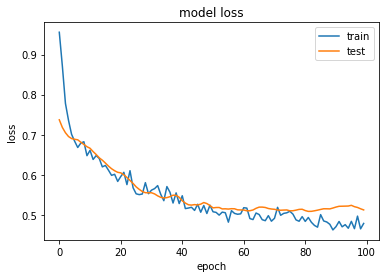

In [15]:
# Plot loss over time.
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

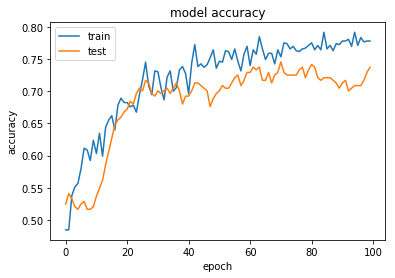

In [16]:
# Plot accuracy over time.
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

<details> <summary> How might we improve the performance of this model?
</summary>
```
- Our test error looks as though it's leveled off, but it's possible we're in a local minimum. If so, our model would be suffering from some error due to bias. We can account for that by:
    - increasing the number of epochs.
    - building a deeper network.
    - regularizing less than we are now (perhaps dropout is inflating our bias, for example).
    - adding more features!
    - If we try these things and our model continually performs worse, then we have evidence that our model is at risk of overfitting, so we wouldn't want to make our model more complex.
- We might also return to "standard" classification techniques:
    - consider changing our threshold for predicting "yes."
    - we might want to optimize for specificity or sensitivity.
    - luckily our classes look balanced, so no adjustment is needed there.
```
</details>

<details> <summary> What changes would I make to turn this into a regression problem?
</summary>
```
- Instead of predicting Y in {higher, lower}, we want to predict the change in the price, which can *theoretically* be anywhere between negative infinity and positive infinity.
    - Change the output layer to only have one node.
    - Change the final activation function to be linear.
- Note: It'll be easier for us to predict higher versus lower than to predict the exact amount of change in a stock price.
```
</details>